데이터 불러오기

In [38]:
# !pip install tensorflow

In [142]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import re
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [144]:
# CSV 파일 경로 설정
data_file_path = '/content/drive/MyDrive/Colab Notebooks/ChatbotData .csv'

# 데이터 로드
chatbot_data = pd.read_csv(data_file_path)

# 데이터 확인print("데이터 샘플:")
print(chatbot_data.head())

# 데이터 구조 확인print("\n데이터 정보:")
print(chatbot_data.info())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB
None


데이터 전처리

In [161]:
# 데이터 불러오기
questions = chatbot_data['Q'].tolist()
answers = chatbot_data['A'].tolist()

# 전처리 함수 정의
def preprocess_sentence(sentence):
    """
    한국어 문장을 전처리합니다.
    - 불필요한 공백 제거
    - 특수 문자 제거
    - 소문자로 변환 (필요한 경우)
    """
    sentence = sentence.strip()  # 앞뒤 공백 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)  # 여러 공백을 하나로 변환
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)  # 한글, 영어, 숫자, 일부 특수문자 제외 모두 제거
    sentence = sentence.strip()  # 다시 한번 앞뒤 공백 제거
    return sentence

# 데이터셋 전처리
questions = [preprocess_sentence(sentence) for sentence in questions]
answers = [preprocess_sentence(sentence) for sentence in answers]

# 전처리된 데이터 확인
print("전처리된 질문 샘플:")
print(questions[:5])

print("\n전처리된 답변 샘플:")
print(answers[:5])

전처리된 질문 샘플:
['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']

전처리된 답변 샘플:
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


SubwordTextEncoder 토크나이저

In [162]:
# import tensorflow_datasets as tfds

# # 질문과 답변을 합쳐서 토크나이저 학습 데이터로 사용
# tokenizer_corpus = questions + answers

# # SubwordTextEncoder를 이용해 토크나이저 생성
# tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#     tokenizer_corpus, target_vocab_size=2**13  # 약 8000개의 단어로 구성된 어휘집 생성
# )


# # START_TOKEN과 END_TOKEN 정의
# START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]


# # 어휘 크기 확인
# vocab_size = tokenizer.vocab_size

# # 어휘 크기 업데이트 (새로운 토큰 추가)
# vocab_size += 2  # START_TOKEN과 END_TOKEN을 포함
# print(f"어휘 사전 크기: {vocab_size}")

# # 샘플 데이터를 토크나이징
# sample_question = questions[0]
# sample_answer = answers[0]

# encoded_question = tokenizer.encode(sample_question)
# encoded_answer = tokenizer.encode(sample_answer)

# # 디코딩 테스트
# decoded_question = tokenizer.decode(encoded_question)
# decoded_answer = tokenizer.decode(encoded_answer)

# # 결과 확인
# print(f"원문 질문: {sample_question}")
# print(f"토큰화된 질문: {encoded_question}")
# print(f"복원된 질문: {decoded_question}")

# print(f"\n원문 답변: {sample_answer}")
# print(f"토큰화된 답변: {encoded_answer}")
# print(f"복원된 답변: {decoded_answer}")


# Tokenizer
tokenizer_corpus = questions + answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    tokenizer_corpus, target_vocab_size=2**13
)

# Add START and END Tokens
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
vocab_size = tokenizer.vocab_size + 2

# Encode and Pad Sequences
max_seq_len = 40
input_sequences = [[START_TOKEN[0]] + tokenizer.encode(sentence) + [END_TOKEN[0]] for sentence in questions]
target_sequences = [[START_TOKEN[0]] + tokenizer.encode(sentence) + [END_TOKEN[0]] for sentence in answers]
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')

# # Split Data
# train_size = int(0.8 * len(input_sequences))
# input_train, target_train = input_sequences[:train_size], target_sequences[:train_size]
# input_val, target_val = input_sequences[train_size:], target_sequences[train_size:]

# # Decoder Outputs
# target_train_padded = pad_sequences(target_train[:, 1:], maxlen=max_seq_len, padding='post')
# target_val_padded = pad_sequences(target_val[:, 1:], maxlen=max_seq_len, padding='post')

# Split Data
train_size = int(0.8 * len(input_sequences))
input_train, target_train = input_sequences[:train_size], target_sequences[:train_size]
input_val, target_val = input_sequences[train_size:], target_sequences[train_size:]

# Decoder Outputs: Pad to match max_seq_len
decoder_input_train = pad_sequences(target_train[:, :-1], maxlen=max_seq_len, padding='post')  # 디코더 입력 패딩
decoder_input_val = pad_sequences(target_val[:, :-1], maxlen=max_seq_len, padding='post')      # 검증 데이터 디코더 입력

target_train_padded = pad_sequences(target_train[:, 1:], maxlen=max_seq_len, padding='post')   # 디코더 출력 패딩
target_val_padded = pad_sequences(target_val[:, 1:], maxlen=max_seq_len, padding='post')       # 검증 데이터 디코더 출력


In [163]:
# Custom Loss Function to Ignore Padding
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

def custom_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Ignore padding tokens
    loss_ = loss_object(real, pred)  # Use the updated loss_object
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # Apply mask to ignore padding
    return tf.reduce_mean(loss_)

In [64]:
# # 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
# def tokenize_and_filter(inputs, outputs):
#   tokenized_inputs, tokenized_outputs = [], []

#   for (sentence1, sentence2) in zip(inputs, outputs):
#     # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
#     sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
#     sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

#     # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
#     if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
#       tokenized_inputs.append(sentence1)
#       tokenized_outputs.append(sentence2)

#   # 최대 길이 40으로 모든 데이터셋을 패딩
#   tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
#   tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

#   return tokenized_inputs, tokenized_outputs

In [141]:
# import numpy as np
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # START_TOKEN 및 END_TOKEN 정의
# START_TOKEN = [tokenizer.vocab_size]
# END_TOKEN = [tokenizer.vocab_size + 1]
# vocab_size = tokenizer.vocab_size + 2  # START/END 토큰 포함

# # 데이터 정수 인덱스로 변환
# input_sequences = [tokenizer.encode(sentence) for sentence in questions]
# target_sequences = [tokenizer.encode(sentence) for sentence in answers]

# # START/END 토큰 추가
# input_sequences = [[START_TOKEN[0]] + seq + [END_TOKEN[0]] for seq in input_sequences]
# target_sequences = [[START_TOKEN[0]] + seq + [END_TOKEN[0]] for seq in target_sequences]

# # 시퀀스 패딩
# max_seq_len = 40
# input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
# target_sequences = pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')

# # 데이터 크기 조정
# input_sequences = input_sequences[:5000]
# target_sequences = target_sequences[:5000]

# # 훈련/검증 데이터 분할
# train_size = int(0.8 * len(input_sequences))
# input_train = input_sequences[:train_size]
# target_train = target_sequences[:train_size]
# input_val = input_sequences[train_size:]
# target_val = target_sequences[train_size:]

# # 디코더 출력 준비
# target_train_padded = pad_sequences(target_train[:, 1:], maxlen=max_seq_len, padding='post')
# target_val_padded = pad_sequences(target_val[:, 1:], maxlen=max_seq_len, padding='post')



In [164]:
# Positional Encoding
def get_positional_encoding(seq_len, depth):
    angle_rads = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis] / tf.pow(
        10000, (2 * (tf.range(depth // 2, dtype=tf.float32) // 2)) / depth
    )
    pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
    return pos_encoding

In [165]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate):
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(inputs, inputs)
    attention = layers.Dropout(dropout_rate)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    ff = layers.Dense(ff_dim, activation='relu')(attention)
    ff = layers.Dropout(dropout_rate)(ff)
    ff = layers.Dense(inputs.shape[-1])(ff)
    return layers.LayerNormalization(epsilon=1e-6)(attention + ff)

In [166]:
# Transformer Model
def build_transformer_model(input_vocab_size, target_vocab_size, seq_len):
    inputs = layers.Input(shape=(seq_len,))
    targets = layers.Input(shape=(seq_len,))
    input_embed = layers.Embedding(input_vocab_size, embedding_dim)(inputs)
    target_embed = layers.Embedding(target_vocab_size, embedding_dim)(targets)
    input_embed += get_positional_encoding(seq_len, embedding_dim)
    target_embed += get_positional_encoding(seq_len, embedding_dim)
    encoder_output = transformer_encoder(input_embed, embedding_dim, num_heads, ff_dim, dropout_rate)
    decoder_output = transformer_encoder(target_embed, embedding_dim, num_heads, ff_dim, dropout_rate)
    output = layers.Dense(target_vocab_size, activation='softmax')(decoder_output)
    return tf.keras.Model(inputs=[inputs, targets], outputs=output)

In [167]:
# 하이퍼파라미터 설정
embedding_dim = 256  # 임베딩 차원
num_heads = 8        # 어텐션 헤드 수
ff_dim = 1024        # 피드포워드 네트워크 차원
num_layers = 4       # 트랜스포머 레이어 수
dropout_rate = 0.1   # 드롭아웃 비율

# # 포지셔널 인코딩 함수 정의
# def get_positional_encoding(seq_len, depth):
#     angle_rads = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis] / tf.pow(10000, (2 * (tf.range(depth // 2, dtype=tf.float32) // 2)) / depth)
#     pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
#     return pos_encoding

# # 트랜스포머 인코더 레이어 정의
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate):
#     # Multi-Head Attention
#     attention = layers.MultiHeadAttention(
#         num_heads=num_heads, key_dim=head_size, dropout=dropout_rate
#     )(inputs, inputs)
#     attention = layers.Dropout(dropout_rate)(attention)
#     attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)  # Residual Connection

#     # Feed Forward Network
#     ff = layers.Dense(ff_dim, activation='relu')(attention)
#     ff = layers.Dropout(dropout_rate)(ff)
#     ff = layers.Dense(inputs.shape[-1])(ff)
#     ff = layers.LayerNormalization(epsilon=1e-6)(attention + ff)  # Residual Connection

#     return ff

# # 트랜스포머 모델 정의
# def build_transformer_model(input_vocab_size, target_vocab_size, seq_len):
#     # 입력 및 출력 시퀀스 정의
#     inputs = layers.Input(shape=(seq_len,))
#     targets = layers.Input(shape=(seq_len,))

#     # 임베딩 층
#     input_embed = layers.Embedding(input_vocab_size, embedding_dim)(inputs)
#     target_embed = layers.Embedding(target_vocab_size, embedding_dim)(targets)

#     # 포지셔널 인코딩 추가
#     input_pos_encoding = get_positional_encoding(seq_len, embedding_dim)
#     target_pos_encoding = get_positional_encoding(seq_len, embedding_dim)

#     input_embed += input_pos_encoding
#     target_embed += target_pos_encoding

#     # 트랜스포머 인코더
#     encoder_output = transformer_encoder(input_embed, embedding_dim, num_heads, ff_dim, dropout_rate)

#     # 트랜스포머 디코더
#     decoder_output = transformer_encoder(target_embed, embedding_dim, num_heads, ff_dim, dropout_rate)

#     # 출력 층
#     output = layers.Dense(target_vocab_size, activation='softmax')(decoder_output)

#     # 모델 정의
#     model = tf.keras.Model(inputs=[inputs, targets], outputs=output)

#     return model

# # 모델 생성
# input_vocab_size = vocab_size  # 어휘 크기 (토크나이저에서 생성된 어휘 크기 사용)
# target_vocab_size = vocab_size  # 어휘 크기 (입력과 출력 어휘 크기는 동일)
# seq_len = 40  # 최대 시퀀스 길이 (임의로 설정)

# model = build_transformer_model(input_vocab_size, target_vocab_size, seq_len)


# Build and Compile Model
model = build_transformer_model(vocab_size, vocab_size, max_seq_len)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=custom_loss_function, metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 40, 256)        │      2,092,032 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)              │ (None, 40, 256)        │              0 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_11   │ (None, 40, 256)        │      2,103,552 │ add_31[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_31[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 40, 256)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_34 (Add)              │ (None, 40, 256)        │              0 │ add_31[0][0],          │
│                           │                        │                │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_22    │ (None, 40, 256)        │            512 │ add_34[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 40, 1024)       │        263,168 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 40, 1024)       │              0 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 40, 256)        │        262,400 │ dropout_35[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_35 (Add)              │ (None, 40, 256)        │              0 │ layer_normalization_2… │
│                           │                        │                │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_23    │ (None, 40, 256)        │            512 │ add_35[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 40, 8172)       │      2,100,204 │ layer_normalization_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,822,380 (26.03 MB)

 Trainable params: 6,822,380 (26.03 MB)

 Non-trainable params: 0 (0.00 B)

모델 훈련준비
데이터크기, 배치사이즈 등 정하기

In [157]:
# print(input_train.shape, decoder_input_train.shape, target_train_padded.shape)
# print(input_val.shape, decoder_input_val.shape, target_val_padded.shape)


(9458, 40) (4000, 40) (9458, 40)
(2365, 40) (1000, 40) (2365, 40)


In [168]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=custom_loss_function,  # Use updated custom loss
    metrics=['accuracy']
)

In [ ]:
# Train the model

history = model.fit(
    [input_train, decoder_input_train],  # Encoder and decoder inputs
    target_train_padded,  # Padded target tensor
    validation_data=([input_val, decoder_input_val], target_val_padded),  # Validation data
    epochs=10,
    batch_size=32,
    verbose=1
)
# 훈련 결과 출력
print(f"훈련 완료 후 최종 정확도: {history.history['accuracy'][-1]}")

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 749s 3s/step - accuracy: 0.8318 - loss: 0.3219 - val_accuracy: 0.8563 - val_loss: 0.2311
Epoch 2/10
 80/296 ━━━━━━━━━━━━━━━━━━━━ 8:19 2s/step - accuracy: 0.8866 - loss: 0.1440

In [70]:
# 여기서 아웃풋 변수 지정 문제
# # Train the model
# history = model.fit(
#     [input_train, target_train],  # Model inputs: encoder and decoder input sequences
#     target_train_padded,  # Target sequences (decoder output)
#     validation_data=([input_val, target_val], target_val_padded),  # Validation data
#     epochs=10,  # Number of training epochs
#     batch_size=32,  # Batch size
#     verbose=1  # Display progress during training
# )

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8555 - loss: 2.2846 - val_accuracy: 0.9115 - val_loss: 0.7467
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9153 - loss: 0.6554 - val_accuracy: 0.9138 - val_loss: 0.6911
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.9182 - loss: 0.5828 - val_accuracy: 0.9152 - val_loss: 0.6749
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9196 - loss: 0.5509 - val_accuracy: 0.9165 - val_loss: 0.6571
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9225 - loss: 0.5026 - val_accuracy: 0.9195 - val_loss: 0.6234
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9241 - loss: 0.4556 - val_accuracy: 0.9205 - val_loss: 0.6037
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9288 - loss: 0.4028 - val_accuracy: 0.9221 - val_loss: 0.5946
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9292 - loss: 0.3776 - val_accu

In [74]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(
    [input_val, decoder_input_val],
    target_val_padded,
    verbose=1
)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step - accuracy: 0.9299 - loss: 0.5431
Validation Loss: 0.5263464450836182
Validation Accuracy: 0.9317498207092285


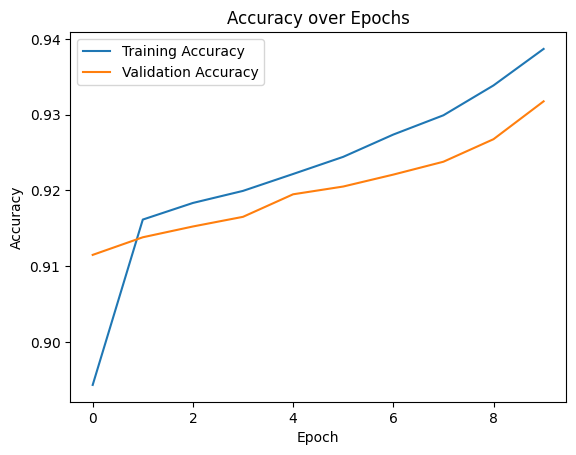

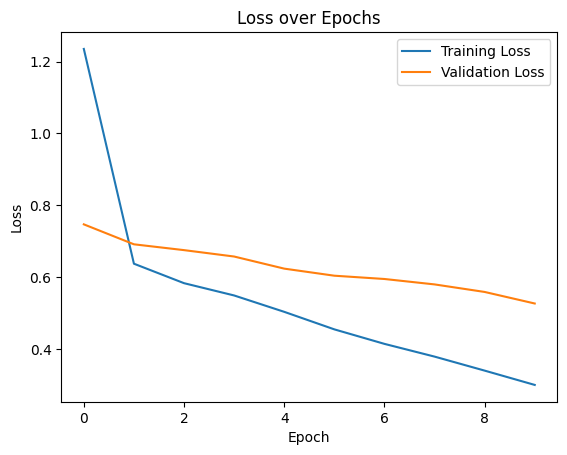

In [71]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

테스트 시작

In [138]:
# Preprocess Input
def preprocess_input(user_input):
    processed_input = preprocess_sentence(user_input)
    tokenized_input = [START_TOKEN[0]] + tokenizer.encode(processed_input) + [END_TOKEN[0]]
    return pad_sequences([tokenized_input], maxlen=max_seq_len, padding='post')

# def preprocess_input(user_input):
#     # Step 1: Preprocess user input (cleaning)
#     processed_input = preprocess_sentence(user_input)
#     print(f"Processed input: {processed_input}")  # Debugging

#     # Step 2: Tokenize input
#     tokenized_input = tokenizer.encode(processed_input)
#     print(f"Tokenized input: {tokenized_input}")  # Debugging

#     # Step 3: Add START and END tokens
#     tokenized_input = [START_TOKEN[0]] + tokenized_input + [END_TOKEN[0]]
#     print(f"Tokenized input with START/END tokens: {tokenized_input}")  # Debugging

#     # Step 4: Pad the input
#     padded_input = pad_sequences([tokenized_input], maxlen=max_seq_len, padding='post')
#     print(f"Padded input: {padded_input}")  # Debugging

#     return padded_input



In [ ]:
# Generate Response
def generate_response(input_seq):
    decoder_input = np.zeros((1, max_seq_len))
    decoder_input[0, 0] = START_TOKEN[0]
    response_tokens = []
    for i in range(1, max_seq_len):
        predictions = model.predict([input_seq, decoder_input], verbose=0)
        predicted_token = np.argmax(predictions[0, i - 1])
        if predicted_token == END_TOKEN[0]:
            break
        decoder_input[0, i] = predicted_token
        response_tokens.append(predicted_token)
    return tokenizer.decode([int(token) for token in response_tokens if token != 0])

# def generate_response(input_seq):
#     decoder_input = np.zeros((1, max_seq_len))
#     decoder_input[0, 0] = START_TOKEN[0]

#     response_tokens = []
#     print("Generating response...")

#     for i in range(1, max_seq_len):
#         predictions = model.predict([input_seq, decoder_input], verbose=0)
#         predicted_token = np.argmax(predictions[0, i - 1])

#         # Debugging: Print token probabilities
#         print(f"Step {i}: Predicted token: {predicted_token}")
#         print(f"Step {i}: Token probabilities: {predictions[0, i - 1]}")

#         if predicted_token == END_TOKEN[0]:
#             print("END_TOKEN predicted. Stopping generation.")
#             break

#         decoder_input[0, i] = predicted_token
#         response_tokens.append(predicted_token)

#     print("Response tokens:", response_tokens)
#     response_text = tokenizer.decode([int(token) for token in response_tokens if token != 0])
#     print("Decoded response:", response_text)
#     return response_text

In [ ]:
# Chat Function
def chat():
    print("Chatbot is ready! Type 'exit' to end the conversation.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            print("Chatbot: Goodbye!")
            break
        input_seq = preprocess_input(user_input)
        response = generate_response(input_seq)
        print(f"Chatbot: {response}")

# def chat():
#     print("Chatbot is ready! Type 'exit' to end the conversation.")
#     while True:
#         try:
#             user_input = input("You: ")
#             if user_input.lower() == 'exit':
#                 print("Chatbot: Goodbye!")
#                 break

#             # Preprocess user input and generate response
#             input_seq = preprocess_input(user_input)
#             response = generate_response(input_seq)
#             print(f"Chatbot: {response}")
#         except KeyboardInterrupt:
#             print("\nChatbot: Interrupted by user. Exiting...")
#             break

In [ ]:
chat()

Response tokens값을 계속 0으로 가져오는 문제가 있어서 아래코드부터는 디버깅을 위한 코드였다.

Questions에 답이 나오지 않고 있어서 문제를 해결해야함
Reponse tokens에서부터 값이 0만 나오는 문제가 있음
모델이 훈련이 잘못되서 결과값이 안나오는건지 원인을 파악해야함

문제는 모델을 훈련시키고 컴파일할때 output의 변수명을 잘못기입한것이 문제였음

디버깅

In [133]:
# print(f"START_TOKEN: {START_TOKEN}, END_TOKEN: {END_TOKEN}")

START_TOKEN: [8170], END_TOKEN: [8171]


In [130]:
# sample_text = "안녕하세요"
# tokenized = tokenizer.encode(sample_text)
# print("Tokenized:", tokenized)
# print("Decoded:", tokenizer.decode(tokenized))

Tokenized: [4154]
Decoded: 안녕하세요


In [131]:
# for i in range(5):  # Print the first 5 pairs
#     print(f"Question {i}: {questions[i]}")
#     print(f"Answer {i}: {answers[i]}")

Question 0: 12시 땡 !
Answer 0: 하루가 또 가네요 .
Question 1: 1지망 학교 떨어졌어
Answer 1: 위로해 드립니다 .
Question 2: 3박4일 놀러가고 싶다
Answer 2: 여행은 언제나 좋죠 .
Question 3: 3박4일 정도 놀러가고 싶다
Answer 3: 여행은 언제나 좋죠 .
Question 4: PPL 심하네
Answer 4: 눈살이 찌푸려지죠 .


In [132]:
# sample_train_input = input_train[0:1]
# print(f"Sample train input: {sample_train_input}")
# response = generate_response(sample_train_input)
# print(f"Response for training input: {response}")

Sample train input: [[7909 4203 3055   41    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Generating response...
Step 1: Predicted token: 0
Step 1: Token probabilities: [9.9845761e-01 1.4569788e-04 5.1478420e-08 ... 6.7952227e-10 7.7711265e-10
 6.2415251e-10]
Step 2: Predicted token: 0
Step 2: Token probabilities: [9.9984050e-01 2.0964080e-06 3.9336578e-09 ... 2.9637626e-10 3.3898787e-10
 2.7957181e-10]
Step 3: Predicted token: 0
Step 3: Token probabilities: [9.9984026e-01 2.0881646e-06 3.9371550e-09 ... 2.9636205e-10 3.3942579e-10
 2.7970615e-10]
Step 4: Predicted token: 0
Step 4: Token probabilities: [9.9984026e-01 2.0591931e-06 3.9559058e-09 ... 2.9659786e-10 3.4007119e-10
 2.7983901e-10]
Step 5: Predicted token: 0
Step 5: Token probabilities: [9.9984169e-01 2.2051786e-06 4.3234407e-09 ... 3.0008018e-10 3.4306985e-10
 2.8107619e-10]
Step 6: Predic

In [ ]:
# print(history.history)

accuracy와 loss의 결과값을 확인해보니 이상 없

In [105]:
# Test the model with a sample from validation data
sample_input = input_val[0:1]
print(f"Validation input sequence: {sample_input}")
response = generate_response(sample_input)
print(f"Generated response for validation input: {response}")


Validation input sequence: [[2008 4213  962    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Generating response...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


KeyboardInterrupt: 

In [107]:
sample_text = "안녕하세요!"
processed_text = preprocess_sentence(sample_text)
print(f"Original: {sample_text}")
print(f"Processed: {processed_text}")

Original: 안녕하세요!
Processed: 안녕하세요 !


In [108]:
print(f"Sample training question: {questions[0]}")
processed_training_question = preprocess_sentence(questions[0])
print(f"Processed training question: {processed_training_question}")

Sample training question: 12시 땡 !
Processed training question: 12시 땡 !


In [109]:
tokenized_input = tokenizer.encode(processed_text)
print(f"Tokenized input: {tokenized_input}")

Tokenized input: [4154, 41]


In [110]:
sample_training_tokens = tokenizer.encode(processed_training_question)
print(f"Tokenized training question: {sample_training_tokens}")

Tokenized training question: [7909, 4203, 3055, 41]


In [111]:
padded_input = pad_sequences([tokenized_input], maxlen=max_seq_len, padding='post')
print(f"Padded input: {padded_input}")

Padded input: [[4154   41    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [112]:
print(f"First training input: {input_train[0]}")

First training input: [7909 4203 3055   41    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [126]:
sample_input = "안녕하세요!"
processed_sample = preprocess_input(sample_input)
print(f"Processed user input: {processed_sample}")

print(f"First training input: {input_train[0]}")

Processed input: 안녕하세요 !
Tokenized input: [4154, 41]
Tokenized input with START/END tokens: [8170, 4154, 41, 8171]
Padded input: [[8170 4154   41 8171    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Processed user input: [[8170 4154   41 8171    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
First training input: [7909 4203 3055   41    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
